Logistic Regression 5-Fold Accuracy: [0.851152   0.84568208 0.85013263 0.84316976 0.85195623], Mean = 0.8484
Decision Tree 5-Fold Accuracy: [0.84286425 0.83905188 0.84250663 0.84084881 0.85145889], Mean = 0.8433
Random Forest 5-Fold Accuracy: [0.84468755 0.84883143 0.84781167 0.84250663 0.84433024], Mean = 0.8456
SVM 5-Fold Accuracy: [0.85280955 0.85098624 0.85676393 0.84781167 0.85460875], Mean = 0.8526

=== Paired t-tests against Logistic Regression ===
LogReg vs Decision Tree: Ttest_relResult(statistic=3.2815197636940945, pvalue=0.03045718970015285)
LogReg vs Random Forest: Ttest_relResult(statistic=1.4202374837635214, pvalue=0.22856594595473032)
LogReg vs SVM: Ttest_relResult(statistic=-4.644250690683157, pvalue=0.009703085353773353)

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4531
           1       0.73      0.60      0.66      1502

    accuracy                           0.85      6033
   ma

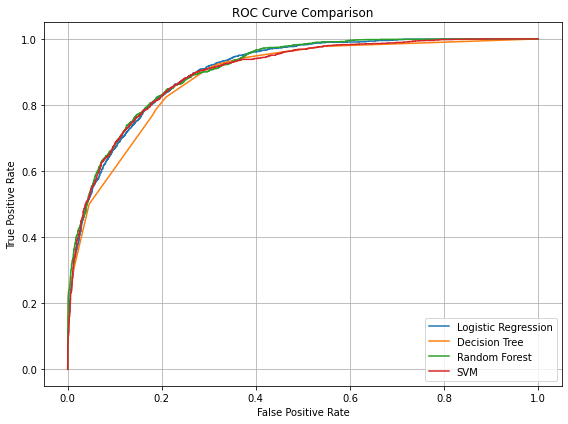


=== Extended Model Performance Summary ===
                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression  0.847174   0.734628  0.604527  0.663258  0.902257
1        Decision Tree  0.840875   0.784664  0.497337  0.608802  0.886680
2        Random Forest  0.844853   0.800425  0.501997  0.617021  0.905248
3                  SVM  0.849826   0.750000  0.595206  0.663697  0.898254


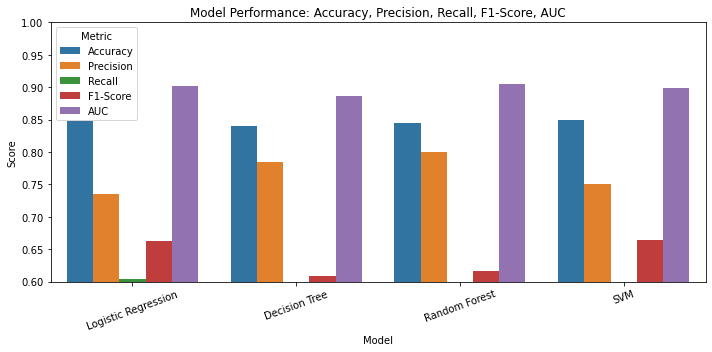


=== Top 5 Features per Model ===
                               Feature  Importance                Model
0   marital-status_ Married-civ-spouse    0.465326        Decision Tree
1                        education-num    0.233018        Decision Tree
2                         capital-gain    0.218701        Decision Tree
3                                  age    0.038559        Decision Tree
4                       hours-per-week    0.022274        Decision Tree
5                         capital-gain    2.475573  Logistic Regression
6   marital-status_ Married-civ-spouse    1.522608  Logistic Regression
7          occupation_ Priv-house-serv    1.474466  Logistic Regression
8                   relationship_ Wife    1.380751  Logistic Regression
9    marital-status_ Married-AF-spouse    1.084411  Logistic Regression
10  marital-status_ Married-civ-spouse    0.164484        Random Forest
11                        capital-gain    0.162825        Random Forest
12               relationship_

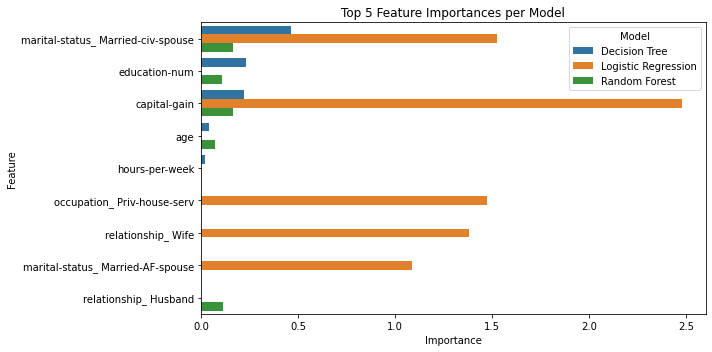

In [1]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import ttest_rel

# === LOAD DATA ===
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv("adult.data", header=None, names=column_names, na_values=" ?")
data.dropna(inplace=True)

X = data.drop("income", axis=1)
y = data["income"].apply(lambda x: 1 if x.strip() == ">50K" else 0)

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# === PREPROCESSING PIPELINE ===
numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

# === MODEL PIPELINES ===
logreg_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000, random_state=42))])
dt_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42))])
rf_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42))])
svm_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", SVC(kernel="rbf", probability=True, random_state=42))])

# === 5-FOLD CV ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline), ("SVM", svm_pipeline)]:
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"{name} 5-Fold Accuracy: {scores}, Mean = {np.mean(scores):.4f}")

# === PAIRED T-TESTS ===
print("\n=== Paired t-tests against Logistic Regression ===")
cv_logreg = cross_val_score(logreg_pipeline, X, y, cv=cv, scoring="accuracy")
for name, model in [("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline), ("SVM", svm_pipeline)]:
    cv_other = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"LogReg vs {name}:", ttest_rel(cv_logreg, cv_other))

# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === TRAIN & EVALUATE ALL MODELS ===
preds = {}
for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline), ("SVM", svm_pipeline)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_prob))
    preds[name] = (y_pred, y_prob)

# === ROC CURVE ===
plt.figure(figsize=(8, 6))
for name, (_, yprob) in preds.items():
    fpr, tpr, _ = roc_curve(y_test, yprob)
    plt.plot(fpr, tpr, label=name)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === EXTENDED SUMMARY TABLE & PLOT ===
summary_df = pd.DataFrame([
    [
        name,
        accuracy_score(y_test, ypred),
        precision_score(y_test, ypred),
        recall_score(y_test, ypred),
        f1_score(y_test, ypred),
        roc_auc_score(y_test, yprob)
    ]
    for name, (ypred, yprob) in preds.items()
], columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"])
print("\n=== Extended Model Performance Summary ===")
print(summary_df)

summary_melted = summary_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 5))
sns.barplot(data=summary_melted, x="Model", y="Score", hue="Metric")
plt.title("Model Performance: Accuracy, Precision, Recall, F1-Score, AUC")
plt.ylim(0.6, 1.0)
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCE ===
def get_feature_df(model_pipeline, model_name):
    model = model_pipeline.named_steps['classifier']
    preprocessor = model_pipeline.named_steps['preprocessor']
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = cat_encoder.get_feature_names(categorical_features)  # sklearn 0.24
    feat_names = numerical_features + list(cat_names)
    if hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        return None
    df = pd.DataFrame({"Feature": feat_names, "Importance": importances})
    df["Model"] = model_name
    return df

logreg_df = get_feature_df(logreg_pipeline, "Logistic Regression")
dt_df = get_feature_df(dt_pipeline, "Decision Tree")
rf_df = get_feature_df(rf_pipeline, "Random Forest")

fi_all = pd.concat([logreg_df, dt_df, rf_df])
top_fi = fi_all.groupby("Model").apply(lambda df: df.nlargest(5, "Importance")).reset_index(drop=True)
print("\n=== Top 5 Features per Model ===")
print(top_fi)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_fi, x="Importance", y="Feature", hue="Model")
plt.title("Top 5 Feature Importances per Model")
plt.tight_layout()
plt.show()



=== Feature Ablation (Top 2) ===

Logistic Regression → Dropping: ['capital-gain', 'marital-status']
Logistic Regression accuracy after ablation: 0.8303

Decision Tree → Dropping: ['marital-status', 'education-num']
Decision Tree accuracy after ablation: 0.8405

Random Forest → Dropping: ['marital-status', 'capital-gain']
Random Forest accuracy after ablation: 0.8188

=== Noise Robustness (σ = 0.1, 0.2, 0.3) ===
σ = 0.1 → Logistic Regression Accuracy = 0.8468
σ = 0.1 → Decision Tree Accuracy = 0.8415
σ = 0.1 → Random Forest Accuracy = 0.8463
σ = 0.1 → SVM Accuracy = 0.8503
σ = 0.2 → Logistic Regression Accuracy = 0.8470
σ = 0.2 → Decision Tree Accuracy = 0.8412
σ = 0.2 → Random Forest Accuracy = 0.8439
σ = 0.2 → SVM Accuracy = 0.8495
σ = 0.3 → Logistic Regression Accuracy = 0.8473
σ = 0.3 → Decision Tree Accuracy = 0.8407
σ = 0.3 → Random Forest Accuracy = 0.8432
σ = 0.3 → SVM Accuracy = 0.8507

=== Training Size Sensitivity ===
Logistic Regression — Train size = 25% → Accuracy = 0.84

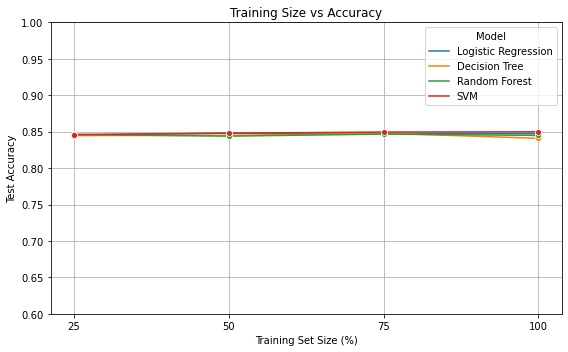

In [2]:


print("\n=== Feature Ablation (Top 2) ===")
for df, original_pipeline, name in [
    (logreg_df, LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"), 
    (dt_df, DecisionTreeClassifier(max_depth=5, random_state=42), "Decision Tree"), 
    (rf_df, RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42), "Random Forest")
]:
    top2 = df.sort_values(by="Importance", ascending=False).head(2)
    
    ablate_feats = []
    for feat in top2["Feature"]:
        if feat in numerical_features:
            ablate_feats.append(feat)
        else:
            original_col = feat.split("_")[0]
            if original_col in categorical_features and original_col not in ablate_feats:
                ablate_feats.append(original_col)

    print(f"\n{name} → Dropping: {ablate_feats}")
    
    # Reconstruct data
    X_clean = data.drop("income", axis=1)
    y_clean = data["income"].apply(lambda x: 1 if x.strip() == ">50K" else 0)
    X_ablate = X_clean.drop(columns=ablate_feats)

    # Update feature lists
    num_feats = [col for col in numerical_features if col not in ablate_feats]
    cat_feats = [col for col in categorical_features if col not in ablate_feats]

    # Rebuild pipeline
    ablate_preprocessor = ColumnTransformer([
        ("num", numeric_transformer, num_feats),
        ("cat", categorical_transformer, cat_feats)
    ])
    updated_pipeline = Pipeline([
        ("preprocessor", ablate_preprocessor),
        ("classifier", original_pipeline)
    ])

    # Train and evaluate
    X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
        X_ablate, y_clean, test_size=0.2, stratify=y_clean, random_state=42)
    updated_pipeline.fit(X_train_a, y_train_a)
    acc = updated_pipeline.score(X_test_a, y_test_a)
    print(f"{name} accuracy after ablation: {acc:.4f}")

# === NOISE ROBUSTNESS ===
print("\n=== Noise Robustness (σ = 0.1, 0.2, 0.3) ===")
def add_noise(df, sigma):
    noisy = df.copy()
    for col in numerical_features:
        noisy[col] += np.random.normal(0, sigma, size=len(df))
    return noisy

for sigma in [0.1, 0.2, 0.3]:
    X_noisy = add_noise(X.copy(), sigma)
    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_noisy, y, test_size=0.2, stratify=y, random_state=42)
    for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline), ("Random Forest", rf_pipeline), ("SVM", svm_pipeline)]:
        model.fit(X_train_n, y_train_n)
        acc = model.score(X_test_n, y_test_n)
        print(f"σ = {sigma:.1f} → {name} Accuracy = {acc:.4f}")

# === TRAINING SIZE SENSITIVITY ===
print("\n=== Training Size Sensitivity ===")
sizes = [0.25, 0.5, 0.75, 1.0]
sensitivity_results = []
for frac in sizes:
    if frac < 1.0:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    else:
        X_frac, y_frac = X_train, y_train
    for name, model in [("Logistic Regression", logreg_pipeline), ("Decision Tree", dt_pipeline),
                        ("Random Forest", rf_pipeline), ("SVM", svm_pipeline)]:
        model.fit(X_frac, y_frac)
        acc = model.score(X_test, y_test)
        sensitivity_results.append((name, int(frac * 100), acc))
        print(f"{name} — Train size = {int(frac*100)}% → Accuracy = {acc:.4f}")

sensitivity_df = pd.DataFrame(sensitivity_results, columns=["Model", "TrainSize", "Accuracy"])
plt.figure(figsize=(8, 5))
sns.lineplot(data=sensitivity_df, x="TrainSize", y="Accuracy", hue="Model", marker="o")
plt.title("Training Size vs Accuracy")
plt.xlabel("Training Set Size (%)")
plt.ylabel("Test Accuracy")
plt.xticks([25, 50, 75, 100])
plt.ylim(0.6, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


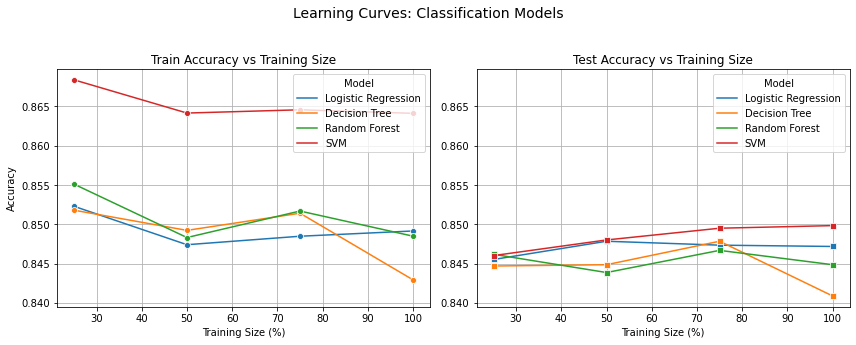


=== Training Time vs Test Accuracy ===
              Model  Train Time (s)  Test Accuracy
Logistic Regression        0.797124       0.847174
      Decision Tree        0.112003       0.840875
      Random Forest        0.873911       0.844853
                SVM       93.295070       0.849826


In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# === 1. LEARNING CURVES (Train vs Test Accuracy) ===
fractions = [0.25, 0.5, 0.75, 1.0]
clf_train, clf_test = [], []

for frac in fractions:
    if frac < 1.0:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    else:
        X_frac, y_frac = X_train, y_train

    for name, model in [("Logistic Regression", logreg_pipeline),
                        ("Decision Tree", dt_pipeline),
                        ("Random Forest", rf_pipeline),
                        ("SVM", svm_pipeline)]:
        model.fit(X_frac, y_frac)
        clf_train.append((name, int(frac * 100), model.score(X_frac, y_frac)))
        clf_test.append((name, int(frac * 100), model.score(X_test, y_test)))

df_clf_train = pd.DataFrame(clf_train, columns=["Model", "TrainSize", "Accuracy"])
df_clf_test = pd.DataFrame(clf_test, columns=["Model", "TrainSize", "Accuracy"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.lineplot(data=df_clf_train, x="TrainSize", y="Accuracy", hue="Model", marker="o", ax=axes[0])
axes[0].set_title("Train Accuracy vs Training Size")
axes[0].set_xlabel("Training Size (%)")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)

sns.lineplot(data=df_clf_test, x="TrainSize", y="Accuracy", hue="Model", marker="s", ax=axes[1])
axes[1].set_title("Test Accuracy vs Training Size")
axes[1].set_xlabel("Training Size (%)")
axes[1].grid(True)
axes[1].tick_params(labelleft=True)

plt.suptitle("Learning Curves: Classification Models", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# === 3. COMPUTATIONAL EFFICIENCY ===
timing_results = []
for name, model in [("Logistic Regression", logreg_pipeline),
                    ("Decision Tree", dt_pipeline),
                    ("Random Forest", rf_pipeline),
                    ("SVM", svm_pipeline)]:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    score = model.score(X_test, y_test)
    timing_results.append((name, end - start, score))

df_time = pd.DataFrame(timing_results, columns=["Model", "Train Time (s)", "Test Accuracy"])
print("\n=== Training Time vs Test Accuracy ===")
print(df_time.to_string(index=False))


In [4]:
# === HYPERPARAMETER SENSITIVITY (Expanded for All Classification Models) ===

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

all_rows = []

# --- Logistic Regression: C + penalty ---
for C in [0.01, 0.1, 1, 10, 100]:
    for penalty in ['l2']:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=1000))
        ])
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        all_rows.append(("Logistic Regression", f"C={C}, penalty={penalty}", acc))

# --- Decision Tree: max_depth + min_samples_split ---
for depth in [2, 5, 10, 15]:
    for min_split in [2, 5, 10]:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split, random_state=42))
        ])
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        all_rows.append(("Decision Tree", f"depth={depth}, min_split={min_split}", acc))

# --- Random Forest: max_depth + n_estimators ---
for depth in [5, 10, 15]:
    for n in [50, 100, 200]:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42))
        ])
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        all_rows.append(("Random Forest", f"depth={depth}, n_estimators={n}", acc))

# --- SVM: C + gamma (RBF Kernel) ---
for C in [0.1, 1, 10]:
    for gamma in ['scale', 0.01, 0.1]:
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(C=C, gamma=gamma, kernel="rbf", probability=True, random_state=42))
        ])
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        all_rows.append(("SVM (RBF)", f"C={C}, gamma={gamma}", acc))

# --- Build and Plot ---
df_hyper = pd.DataFrame(all_rows, columns=["Model", "Hyperparam", "Accuracy"])



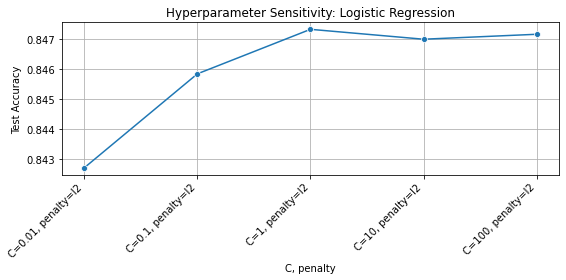

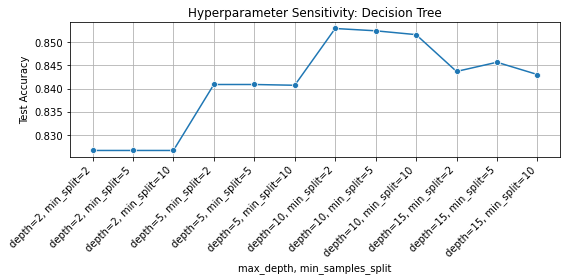

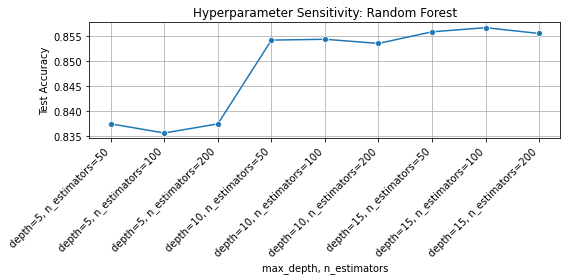

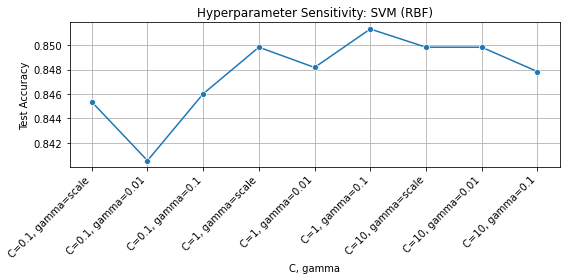

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and plot each model separately
models = df_hyper['Model'].unique()

for model in models:
    df_model = df_hyper[df_hyper["Model"] == model]

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_model, x="Hyperparam", y="Accuracy", marker="o")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True)

    # Custom axis label based on model
    if "Logistic" in model:
        xlab = "C, penalty"
    elif "Decision Tree" in model:
        xlab = "max_depth, min_samples_split"
    elif "Random Forest" in model:
        xlab = "max_depth, n_estimators"
    elif "SVM" in model:
        xlab = "C, gamma"
    else:
        xlab = "Hyperparameter"

    plt.xlabel(xlab)
    plt.ylabel("Test Accuracy")
    plt.title(f"Hyperparameter Sensitivity: {model}")
    plt.tight_layout()
    plt.show()
